In [69]:

#Importar librerias? Pues claro que me importan!
!pip install plotly==4.7.0
!pip install seaborn==0.10.1
import numpy as np
from numpy import random
from random import choices 
import os 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


In [96]:
#Definicion de variables 
mediaincubacion = 7
desvincubacion = 3
mediaduracion = 14
desvduracion = 5
posibilidadContagio = 0.4 #valor inicial, se puede cambiar 
cambioEstadoInicial = 15 
numpersonas = 800
personasedificio = 4
horassimulacion = 1400


In [13]:

def asintomatico_o_no():
    estado = ["asintomatico", "sintomatico"]
    peso_de_decision = [0.6, 0.4]
    n = choices(estado, peso_de_decision)
    return n[0]

def probabilidad_de_muerte(edad):
    if(edad > 65):
        valoracion = [0,1]
        peso = [0.87, 0.13] #queda pendiente revisar esto 
        n = choices(valoracion, peso)
    elif(edad <= 65):
        valoracion = [0,1]
        peso = [0.99, 0.01] #probabilidad que se correspende en caso que no tenga antecentes de ningun tipo
        n = choices(valoracion, peso) #n es un vector cuyo primer elemento es la valoracion 
    return n[0]
    

In [14]:
#Objeto que simula a una persona.
class Persona:
        def __init__(self, idpersona,edad,lugaroriginal, dni):           
            self.idpersona=idpersona
            self.edad=edad
            self.estadosposibles=["sano","incubando","incubandoContagioso","sintomatico","asintomatico","muerto","inmune"]
            self.estado=self.estadosposibles[0]
            self.lugar=lugaroriginal
            self.lugaroriginal=lugaroriginal
            self.diasestado=0 #esto se usa?
            self.cambioEstado=np.inf  #Atributo que indica que dia cambiara la persona de estado.
            self.contadorInfecciones=0
            self.dni = dni
            self.edificiomuerte=-1
            
             
           
        def __str__(self):
            #Devuelve un string con la informacion util del sujeto
            return str(self.idpersona) + "," + str(self.estado) + "," + str(self.lugar) + "," +str(self.dni) + "," +str(self.edad)            

        def puede_propagar(self):
            return ((self.estado == "sintomatico") or (self.estado == "asintomatico") or (self.estado == "incubandoContagioso"))
        def susceptible(self):
            return (self.estado == "sano")
        
        def esta_sano(self):
            return (self.estado == "sano") or (self.estado == "inmune")
        
        def infectar(self,posibilidadContagio,ciudad,mediaincubacion,desvincubacion,diaactual): #media y desv covid: 7.5 y 3.5
            if self.puede_propagar():
                for i in range(len(ciudad[self.lugar])): 
                    if (ciudad[self.lugar][i].susceptible()):
                        nocontagia=random.uniform(0, 1)   #Numero al azar, si es menor que la pos. de contagio, contagiara
                        if (nocontagia <posibilidadContagio/24):
                            ciudad[self.lugar][i].contagiarse(posibilidadContagio,ciudad,mediaincubacion,desvincubacion,diaactual)
                           # print(ciudad[self.lugar][i].cambioEstado)
                            self.contadorInfecciones +=1
                            
                            
        def contagiarse(self,posibilidadContagio,ciudad,mediaincubacion,desvincubacion,diaactual):
            self.estado=self.estadosposibles[1]
            self.diasestado=0
            self.cambioEstado=diaactual+(random.randint(int(mediaincubacion-desvincubacion),int(mediaincubacion+desvincubacion))/2)
                           
                            
        def transicionEstados(self, dia, mediaincubacion,desvincubacion,mediaduracion,desvduracion):
            #A partir de aqui se comprueba que estado posee la persona
            #Y se mira dos casos:
            #Si el dia del cambio de estado , coincide con el dia actual
            if(self.estado == "sintomatico"):
                me_voy_a_morir = probabilidad_de_muerte(self.edad)
                if(me_voy_a_morir == 1):
                    self.cambioEstado=np.inf
                    self.estado = "muerto"
            
            if(self.cambioEstado <= dia):
                if(self.estado == "incubando"):
                    self.estado = "incubandoContagioso" #se le asigna el siguiente estado  
                    self.cambioEstado = dia + random.randint(int(mediaincubacion-desvincubacion),int(mediaincubacion+desvincubacion))/2    #tiempo que pasa a inmune o muerto xD

                elif(self.estado == "incubandoContagioso"):
                    self.estado = asintomatico_o_no() #se le asigna el siguiente estado 
                    self.cambioEstado =dia+ random.randint(int(mediaduracion-desvduracion),int(mediaduracion+desvduracion)) #tiempo que pasa a inmune o muerto xD

                elif(self.estado == "sintomatico"):
                    self.cambioEstado = np.inf 
                    self.estado = "inmune"
                    '''
                      Y ahora una vez que pasa a ser asintomatico o no, se debe ver la probabilidad de que la persona se vaya 
                       a morir o no, y dependiendo de eso, se ha asignan unos dias...
                    '''

                elif(self.estado == "asintomatico"):
                    self.estado = "inmune"
                    self.cambioEstado = np.inf 
                                     
                

In [88]:

class Simulador:
        def __init__(self, numpersonas,personasedificio,mediaincubacion,desvincubacion,mediaduracion ,desvduracion,posibilidadContagio ,cambioEstadoInicial):           
            self.ciudad=crearciudadv0(numpersonas,personasedificio)
            self.dia=0 #se inicializa el dia con un valor de 0 
            self.hora=0 #se inicializa las horas con un valor de 0 
            self.numpersonasinicial=numpersonas 
            self.numpersonas=numpersonas
            self.numedificios=len(self.ciudad)
            self.capacidades=np.zeros(self.numedificios)
            self.CatalogoPersonas=[]
            self.cementerio=[]
            for i in range(self.numedificios-1,-1,-1):
                self.capacidades[i]=int(len(self.ciudad[i])) #establecemos las capacidades de los edificios
                for j in range (len(self.ciudad[i])):
                    self.CatalogoPersonas.append(self.ciudad[i][j])
                    
            self.capacidades=self.capacidades.astype(int)
            print(self.capacidades)
            #for i in range(len(self.CatalogoPersonas)):
            #    print(self.CatalogoPersonas[i])
            self.mediaincubacion = mediaincubacion
            self.desvincubacion = desvincubacion
            self.mediaduracion = mediaduracion
            self.desvduracion = desvduracion
            self.posibilidadContagio = posibilidadContagio #valor inicial, se puede cambiar 
            self.cambioEstadoInicial = cambioEstadoInicial
            self.RegistroSanos=[numpersonas]
                
           
        def __str__(self):
            #Devuelve un string con la informacion util del simulador
            return str(self.dia) + "," + str(self.hora) + "," + str(self.numpersonas) + "," +str(self.numedificios)  
        
        def actualizar_catalogo(self):#actualizamos los datos de las personas ordenadas por id
            nuevoCatalogo=[]
            for i in range(self.numedificios):
                for j in range (len(self.ciudad[i])):
                    nuevoCatalogo.append(self.ciudad[i][j]) #primero cogemos todas las personas sin ordenar
                    self.CatalogoPersonas = sorted(nuevoCatalogo, key=lambda x: x.idpersona, reverse=False)
            
        #Hace que el simulador avance una hora , con sus consecuencias en las personas
        def pasar_tiempo(self):
            self.RegistroSanos.append(self.personas_sanas())
            if ((self.hora % 8)==0): #barajar a las personas cada 8 horas( hacen shuffle)
                self.moverpersonas2()
                #print("owo")
            for j in range(len(self.ciudad)): #recorre los edificios 
                for i in range(len(self.ciudad[j])): #recorre las personas 
                    self.ciudad[j][i].infectar(self.posibilidadContagio,self.ciudad,self.mediaincubacion,self.desvincubacion,self.dia) #pasa a infectar 
            if (self.hora<23):
                self.hora+=1
            else:#comienza un nuevo dia
                self.hora=0
                self.dia+=1
                for j in range(len(self.ciudad)):
                    for i in range(len(self.ciudad[j])):                     
                        self.ciudad[j][i].transicionEstados(self.dia, self.mediaincubacion,self.desvincubacion,self.mediaduracion,self.desvduracion)
                        
                for j in range(len(self.ciudad)):
                    for i in range(len(self.ciudad[j])-1,-1,-1):   
                        if (self.ciudad[j][i].estado=="muerto"):
                            
                            self.cementerio.append(self.ciudad[j].pop(i))
                            self.numpersonas-=1
                self.cementerio=sorted(self.cementerio, key=lambda x: x.idpersona, reverse=False)
                
                            
        
        #Función que devuelve el total de personas sanas o que ya pasaron la enfermedad de la ciudad
        def personas_sanas(self):
            contador_sanos=0
            for j in range(len(self.ciudad)): #se recorre los edificios de la ciudad
                    for i in range(len(self.ciudad[j])): #se va recorriendo las personas de los edificios 
                        if self.ciudad[j][i].esta_sano():
                            contador_sanos+=1
            return contador_sanos
        
        def cogerpersona(self, idpersona):
            self.actualizar_catalogo()
            return self.CatalogoPersonas[idpersona]
        
        
        
        def moverpersonas(self):#Baraja a todas las personas de la ciudad indiscriminadamente
                                #Vamos a crear una nueva ciudad utilizando las personas actuales
            print(f"Total de vivos:{self.numpersonas}")
            personasColocadas=0
            edificiosSinVaciar=self.numedificios
            ciudadnueva=[] #la nueva ciudad
            for i in range(self.numedificios-1,-1,-1):
                if (len(self.ciudad[i])==0):
                    del self.ciudad[i]
                    edificiosSinVaciar-=1
            
            for i in range(self.numedificios):
                edificionuevo = [] #El edificio actual de la ciudad nueva.
                
                for j in range(self.capacidades[i]):
                    if personasColocadas==self.numpersonas:
                        break
                    
                    if edificiosSinVaciar>1:
                        edificioescogido=random.randint(0,edificiosSinVaciar)
                    else:
                        edificioescogido=0
                    edificionuevo.append(self.ciudad[edificioescogido].pop(0))
                    edificionuevo[j].lugar=i
                    personasColocadas+=1
                    if (personasColocadas==self.numpersonas):
                        break
                    if (len(self.ciudad[edificioescogido])==0):
                        del  self.ciudad[edificioescogido]
                        edificiosSinVaciar-=1
            
                ciudadnueva.append(edificionuevo)
            self.ciudad=ciudadnueva
            
        def moverpersonas2(self):
            print(f"Total de vivos:{self.numpersonas}")
            personasColocadas=0
            edificiosAntiguos=self.numedificios
            ciudadnueva=[] #la nueva ciudad
            opciones=[]
            for i in range(self.numedificios):
                edificionuevo=[]
                ciudadnueva.append(edificionuevo)
                opciones.append(i)
            
            personasColocadas=0
            edificiosLlenos=self.numedificios
            
            for i in range(self.numedificios):
                for j in range(len(self.ciudad[i])):
                    if (len(self.ciudad[i])==0):
                        break
                    edificioALlenar=random.choice(opciones)
                    self.ciudad[i][0].lugar=edificioALlenar
                    ciudadnueva[edificioALlenar].append(self.ciudad[i].pop(0))
                    if (len(ciudadnueva[edificioALlenar])==self.capacidades[edificioALlenar]):
                        opciones.remove(edificioALlenar)
            self.ciudad=ciudadnueva
            
            
        #Función que contagia a la primera persona (la deja sintomática), se usa para crear pacientes 0
        def contagio_fijo(self, cambioEstadoInicial):
            self.ciudad[0][0].estado=self.ciudad[0][0].estadosposibles[3]
            self.ciudad[0][0].cambioEstado= self.cambioEstadoInicial
            
            
        def mostrarcementerio(self):#pues eso
            print(f"Total de muertos:{len(self.cementerio)}")
            for j in range(len(self.cementerio)):
                print(self.cementerio[j])
        def  graficoPersonasSanas(self):   
            arr=np.reshape(self.RegistroSanos, (len(MiSimulador.RegistroSanos), 1)).T[0]
            data=pd.DataFrame({'horas':range(0,len(MiSimulador.RegistroSanos)),'personas_sanas':arr})
            sns.relplot(x="horas",y="personas_sanas", kind="line", data=data)

In [89]:
#Funcion que se encarga de generar la edad de manera aleatoria
def generador_edad():
        n = random.randint(0,110) #el rango de edad, sera desde los 0 años hasta los 110
        return n


In [90]:
#Funcion que se encarga de generar numeros aleatorios 
def generador_numeros(longitud):
    numero=0
    for i in range(0,longitud): 
        n = random.randint(0,9)
        numero=10*numero+n
    return numero


In [91]:
#Funcion que se encarga de crear una secuencia valida de DNI
#Para ello, se ha utilizado el algoritmo que se usa en la vida real -en cuanto a la relacion numero y letra- 
def creaDni():
    letras = "TRWAGMYFPDXBNJZSQVHLCKEO" #conjunto de letras del dni
    input=generador_numeros(8)
    #Se consigue que toda la secuencia de numeros sea 1 solo
    
    #Se calcula la letra que ha de ser adicionada
    valor =int(input / 23)
    #print(f"El valor en este caso es: {valor}")
    valor *= 23
    valor = input - valor;
    #Ahora, ha de pasarse el numero de la secuencia
    #a una lista donde cada elemento es un numero de la secuencia 
    DNI=str(input)+letras[valor]
    
    return DNI

In [92]:
#Esta función crea la ciudad en la versión 0 de la simulacion.
#La ciudad es una lista de edificios y cada edificio es una lista de personas de tamaño variable.
#Input: personas de la ciudad, media de personas por edificio.
#Output: la ciudad.
def crearciudadv0(numpersonas,personasedificio):
    edificios = [] #La ciudad.
    capacidadusada=0 #Numero de personas metidas en la ciudad.
    edificioactual=0
    while (capacidadusada < numpersonas):
        column = [] #El edificio.
        esteedificio=random.randint(1,personasedificio*3) 
        '''
        Maximo de personas en el edificio. 
        Si usamos desviación tipica de capacidad de edificio, iria aqui
        '''
        contadoredificio=0 #numero de personas colocadas en este edificio
        #print(f"edificio actual:{edificioactual}")
        
        #Bucle en el que se llena el edificio de personas.
        while (capacidadusada < numpersonas) and (contadoredificio < esteedificio):
            
            #print(f"contador del edificio:{contadoredificio}")
            #print(f"capacidad:{esteedificio}")
            
            #Insercion de persona.
            column.append(Persona(capacidadusada,generador_edad(),edificioactual, creaDni()))
            capacidadusada+=1
            contadoredificio+=1
            
            
        #Insercion de edificio en la ciudad
        edificios.append(column)
        edificioactual+=1
        
    return edificios
def printearciudad(ciudad):        
    for j in range(len(ciudad)):
        for i in range(len(ciudad[j])):
            print(ciudad[j][i])
        print()        
        
#Funcion que dada la ciudad, y un indice, permite imprimir el edificio que corresponda a ese indice
def printearEdificio(ciudad , i):
     for j in range(len(ciudad[i])):
        print(ciudad[i][j])
    


[ 6  6  1  5  7  5  5  4  3  2  5 10 10  4  1  9  9  5  6 11  4 11  6  2
  4 11  7  4  8 10  3  9  9  8  3  8  6  9  6  2  6  9  8  2  2  9 11  1
  1  6 10  5  8 10  7  9  8  8  2 11  6  2  3  6  6  1  2  6 11  9  6  7
 10  7  3  8 11  8  1  9  9  6  6  9  8  8  1  8  4  7  5  1  3  5  9 11
  6 10  7  5  5  7  1  9  2  2  4 10  1  1  9 10  6  5 11 11  7  3  2  8
  3  3 11 11  8  9  2  7  1  4]
0,0,800,130
Total de vivos:800
Total de vivos:800
Total de vivos:800
--------
 
 
1
[ 6  6  1  5  7  5  5  4  3  2  5 10 10  4  1  9  9  5  6 11  4 11  6  2
  4 11  7  4  8 10  3  9  9  8  3  8  6  9  6  2  6  9  8  2  2  9 11  1
  1  6 10  5  8 10  7  9  8  8  2 11  6  2  3  6  6  1  2  6 11  9  6  7
 10  7  3  8 11  8  1  9  9  6  6  9  8  8  1  8  4  7  5  1  3  5  9 11
  6 10  7  5  5  7  1  9  2  2  4 10  1  1  9 10  6  5 11 11  7  3  2  8
  3  3 11 11  8  9  2  7  1  4]
1,0,800,130
729,sano,0,12167530R,52
377,sano,0,47601863M,63
744,sano,0,58283070N,20
750,sano,0,61657610S,102
337,incubando

--------
 
 
2
[ 6  6  1  5  7  5  5  4  3  2  5 10 10  4  1  9  9  5  6 11  4 11  6  2
  4 11  7  4  8 10  3  9  9  8  3  8  6  9  6  2  6  9  8  2  2  9 11  1
  1  6 10  5  8 10  7  9  8  8  2 11  6  2  3  6  6  1  2  6 11  9  6  7
 10  7  3  8 11  8  1  9  9  6  6  9  8  8  1  8  4  7  5  1  3  5  9 11
  6 10  7  5  5  7  1  9  2  2  4 10  1  1  9 10  6  5 11 11  7  3  2  8
  3  3 11 11  8  9  2  7  1  4]
2,0,800,130
530,sano,0,53784764T,93
654,sano,0,20163732T,76
633,sano,0,78000361R,88
566,sano,0,43341043G,26
477,sano,0,32438187E,17
66,sano,0,13088455Y,100

758,sano,1,25848252R,53
716,sano,1,7872631F,104
360,sano,1,80056658Y,82
134,sano,1,11108176G,98
250,sano,1,85682374Z,19
54,sano,1,11146021Z,109

47,sano,2,71305331H,29

346,sano,3,72426743L,44
376,sano,3,30231310H,66
500,sano,3,76068076S,42
239,sano,3,30811263A,74
599,sano,3,21475425A,1

761,sano,4,31777857E,30
63,sano,4,55411885D,33
435,sano,4,30664165J,100
73,sano,4,85767068E,101
546,sano,4,83460465C,13
792,sano,4,5741474F,75

374,sano,16,6040321S,24
386,sano,16,67273456C,44
85,sano,16,23407375E,103
263,sano,16,66708014X,57
770,sano,16,11763034Y,87
75,sano,16,48671027Z,12
283,sano,16,44564862Q,1

0,sintomatico,17,35412670F,55
134,sano,17,11108176G,98
277,sano,17,27366468X,108
70,sano,17,1304106Y,20
11,sano,17,13828310C,102

557,sano,18,81713067R,63
777,sano,18,22361465Z,62
514,sano,18,12875001S,98
15,sano,18,32121534X,87
437,sano,18,8880255R,59
597,sano,18,13758478Q,107

663,sano,19,56476251G,78
632,sano,19,85708521X,58
292,sano,19,37147323T,80
595,sano,19,31060253H,37
296,sano,19,71273421D,7
325,sano,19,73501015F,12
372,sano,19,47222212S,52
413,sano,19,44060007B,34
269,sano,19,34822602G,85
706,sano,19,4626241K,75
758,sano,19,25848252R,53

744,sano,20,58283070N,20
122,sano,20,85165225C,46
94,sano,20,10472325B,82
532,sano,20,35548750L,3

141,sano,21,46102451D,71
393,sano,21,1476535G,92
767,sano,21,75678630M,77
201,sano,21,67358746A,79
375,sano,21,61055745Z,91
794,sano,21,11766785P,45
482,sano,21,1363152B,91
3

71,sano,37,35323370Q,72
141,sano,37,46102451D,71

451,sano,38,86233280R,59
118,sano,38,2804805R,102
34,sano,38,6888482M,82
23,sano,38,37400156V,59
455,sano,38,61781487Z,56
166,sano,38,48876080E,56

666,sano,39,41370577V,88
74,sano,39,23282148F,15

466,sano,40,88671420A,0
126,sano,40,40461165W,79
443,sano,40,18283264N,9
536,sano,40,52823415M,17
288,sano,40,21204812P,22
489,sano,40,77701075Z,38

438,sano,41,70784638E,37
678,sano,41,54874464Y,91
17,sano,41,63668531T,103
392,sano,41,48630835A,90
461,sano,41,17257326N,51
452,sano,41,73718183D,67
328,sano,41,14516487Z,66
433,sano,41,58414265S,23
393,sano,41,1476535G,92

121,sano,42,86713520R,107
740,sano,42,58057256N,45
19,sano,42,34715376G,78
70,sano,42,1304106Y,20
730,sano,42,36885384P,15
445,sano,42,83182146R,75
315,sano,42,6256504K,45
351,sano,42,15665134H,74

233,sano,43,46725030R,87
441,sano,43,25385268F,22

364,sano,44,70408574P,31
692,sano,44,12030123L,90

216,sano,45,18623031T,74
680,sano,45,55456232N,56
422,sano,45,75332567T,43
162

376,incubando,95,30231310H,66

172,sano,96,36735018Q,69
510,sano,96,46744004T,93
214,sano,96,55037585B,74
204,sano,96,10227360L,22
238,sano,96,30717468W,108
621,sano,96,51700533Y,21

137,sano,97,72073581E,105
313,sano,97,64325000A,82
664,sano,97,7220114T,55
7,sano,97,64416627K,46
748,sano,97,464058X,27
333,sano,97,20847237Z,46
731,sano,97,63315208A,61
82,sano,97,38060044N,47
386,sano,97,67273456C,44
611,sano,97,75322450A,38

360,sano,98,80056658Y,82
558,incubando,98,30525244N,102
663,sano,98,56476251G,78
606,sano,98,23088136T,63
208,sano,98,50250005L,105
719,sano,98,33062547R,79
394,sano,98,35661204A,9

209,incubando,99,67531016A,99
534,sano,99,62704627A,26
654,sano,99,20163732T,76
678,sano,99,54874464Y,91
670,sano,99,57535074E,69

402,sano,100,40754616L,97
706,sano,100,4626241K,75
721,sano,100,26320738K,72
694,sano,100,503761S,17
114,sano,100,3677214C,3

251,sano,101,3731615A,101
249,sano,101,43300271B,44
99,sano,101,80750107M,103
250,sano,101,85682374Z,19
441,sano,101,25385268F,22
18

--------
 
 
7
[ 6  6  1  5  7  5  5  4  3  2  5 10 10  4  1  9  9  5  6 11  4 11  6  2
  4 11  7  4  8 10  3  9  9  8  3  8  6  9  6  2  6  9  8  2  2  9 11  1
  1  6 10  5  8 10  7  9  8  8  2 11  6  2  3  6  6  1  2  6 11  9  6  7
 10  7  3  8 11  8  1  9  9  6  6  9  8  8  1  8  4  7  5  1  3  5  9 11
  6 10  7  5  5  7  1  9  2  2  4 10  1  1  9 10  6  5 11 11  7  3  2  8
  3  3 11 11  8  9  2  7  1  4]
7,0,800,130
165,sano,0,77236674Y,82
374,sano,0,6040321S,24
133,incubandoContagioso,0,36847814C,1
306,sano,0,53270600R,52
185,sano,0,84485726X,5
30,sano,0,72134641V,81

249,sano,1,43300271B,44
796,sano,1,8277208Z,107
53,sano,1,57072824A,106
413,incubandoContagioso,1,44060007B,34
715,sano,1,35604758E,105
711,sano,1,40415263P,103

702,sano,2,76533050K,98

529,sano,3,15133463S,25
541,sano,3,26871027N,34
422,sano,3,75332567T,43
343,sano,3,11357426A,97
358,sano,3,74010012Z,77

336,sano,4,3656668J,32
367,sano,4,30553312C,98
226,sano,4,63250237F,89
223,sano,4,56780510L,77
277,sano,4,273664

707,sano,49,10373324W,106
411,incubando,49,52245516G,54
181,sano,49,53131443V,25
383,incubando,49,83556357W,69
89,incubandoContagioso,49,72586053P,32
429,sano,49,27300388D,48

12,sano,50,13483673S,90
513,incubando,50,12578447T,23
631,asintomatico,50,3833155K,26
587,incubando,50,13635450S,91
349,sano,50,48361171Z,2
125,incubando,50,20056100P,29
545,sano,50,84111624A,17
375,sano,50,61055745Z,91
13,sano,50,82664732H,102
166,sano,50,48876080E,56

614,sano,51,3183416D,54
654,incubando,51,20163732T,76
629,sano,51,48071060W,76
372,incubando,51,47222212S,52
786,sano,51,88724201E,25

376,incubandoContagioso,52,30231310H,66
385,incubandoContagioso,52,56624717M,62
503,incubando,52,77713087C,86
787,incubandoContagioso,52,84182743Y,55
463,sano,52,34174012Z,80
371,incubando,52,68676167F,5
330,sano,52,15575576E,28
727,sano,52,35217806E,88

45,sano,53,60461735W,71
398,sano,53,65627324K,90
379,sano,53,43275550S,32
524,sano,53,18607808A,71
641,sano,53,81300447R,7
778,sano,53,7705378X,69
595,sano,53,3106

736,sano,127,43257147N,32
148,sano,127,70351182R,78
507,sano,127,31826848T,31
108,sano,127,12006721P,13

280,sano,128,22320248J,0

273,sano,129,86654146J,101
735,sano,129,52037263Q,31
364,sano,129,70408574P,31
541,incubando,129,26871027N,34

522
 
 
--------
 
 
Total de muertos:0
 
 
--------
Total de vivos:800
Total de vivos:800
Total de vivos:800
--------
 
 
10
[ 6  6  1  5  7  5  5  4  3  2  5 10 10  4  1  9  9  5  6 11  4 11  6  2
  4 11  7  4  8 10  3  9  9  8  3  8  6  9  6  2  6  9  8  2  2  9 11  1
  1  6 10  5  8 10  7  9  8  8  2 11  6  2  3  6  6  1  2  6 11  9  6  7
 10  7  3  8 11  8  1  9  9  6  6  9  8  8  1  8  4  7  5  1  3  5  9 11
  6 10  7  5  5  7  1  9  2  2  4 10  1  1  9 10  6  5 11 11  7  3  2  8
  3  3 11 11  8  9  2  7  1  4]
10,0,800,130
191,incubando,0,44227208W,70
545,sano,0,84111624A,17
113,incubando,0,60055000E,58
90,incubando,0,18680455Q,98
626,sano,0,12075768D,106
209,incubandoContagioso,0,67531016A,99

294,sano,1,34120352J,104
379,sano,1,43275550S,3

Total de vivos:800
Total de vivos:800
--------
 
 
11
[ 6  6  1  5  7  5  5  4  3  2  5 10 10  4  1  9  9  5  6 11  4 11  6  2
  4 11  7  4  8 10  3  9  9  8  3  8  6  9  6  2  6  9  8  2  2  9 11  1
  1  6 10  5  8 10  7  9  8  8  2 11  6  2  3  6  6  1  2  6 11  9  6  7
 10  7  3  8 11  8  1  9  9  6  6  9  8  8  1  8  4  7  5  1  3  5  9 11
  6 10  7  5  5  7  1  9  2  2  4 10  1  1  9 10  6  5 11 11  7  3  2  8
  3  3 11 11  8  9  2  7  1  4]
11,0,800,130
269,incubandoContagioso,0,34822602G,85
257,sano,0,60512835L,95
651,incubando,0,71170628A,84
225,sano,0,47043064Z,38
83,incubando,0,35832705Q,84
664,sano,0,7220114T,55

376,asintomatico,1,30231310H,66
80,incubando,1,80451370S,103
236,sano,1,30225878Z,38
447,incubandoContagioso,1,24514564Z,21
99,incubando,1,80750107M,103
548,sano,1,56188444L,73

118,incubando,2,2804805R,102

639,sano,3,62674712B,101
249,incubandoContagioso,3,43300271B,44
642,sano,3,14266348T,72
130,sano,3,40111012R,7
535,incubando,3,38846365D,34

121,incubandoContag

Total de vivos:800
--------
 
 
12
[ 6  6  1  5  7  5  5  4  3  2  5 10 10  4  1  9  9  5  6 11  4 11  6  2
  4 11  7  4  8 10  3  9  9  8  3  8  6  9  6  2  6  9  8  2  2  9 11  1
  1  6 10  5  8 10  7  9  8  8  2 11  6  2  3  6  6  1  2  6 11  9  6  7
 10  7  3  8 11  8  1  9  9  6  6  9  8  8  1  8  4  7  5  1  3  5  9 11
  6 10  7  5  5  7  1  9  2  2  4 10  1  1  9 10  6  5 11 11  7  3  2  8
  3  3 11 11  8  9  2  7  1  4]
12,0,800,130
685,incubando,0,78340210W,19
597,asintomatico,0,13758478Q,107
381,sano,0,61512066S,44
97,incubandoContagioso,0,81740063H,73
510,incubando,0,46744004T,93
585,incubandoContagioso,0,42213486E,17

428,sano,1,14816266B,82
12,incubando,1,13483673S,90
404,sano,1,30013756K,90
472,incubando,1,472137Q,18
673,incubandoContagioso,1,10878263E,66
632,incubando,1,85708521X,58

108,incubando,2,12006721P,13

30,incubando,3,72134641V,81
245,incubando,3,8226886Q,41
10,sintomatico,3,81871657Y,32
63,asintomatico,3,55411885D,33
762,incubando,3,82406407Y,102

574,incuband

619,incubando,2,12857655B,66

138,incubando,3,38252041M,49
611,incubando,3,75322450A,38
28,incubando,3,67703243Y,54
230,incubandoContagioso,3,18345865F,19
535,incubandoContagioso,3,38846365D,34

789,incubando,4,77558882F,86
447,asintomatico,4,24514564Z,21
577,incubandoContagioso,4,30203645E,39
745,asintomatico,4,60583521A,106
397,incubando,4,80803771X,99
604,asintomatico,4,22806786D,49
562,incubando,4,83073821Y,33

384,incubando,5,11220265Z,59
17,incubando,5,63668531T,103
200,sintomatico,5,3171508S,66
112,asintomatico,5,24508432T,88
91,incubandoContagioso,5,74115534N,50

258,asintomatico,6,82716270J,20
659,incubando,6,53287626F,29
409,incubando,6,25724831K,8
779,incubando,6,60614663A,54
214,incubandoContagioso,6,55037585B,74

229,incubando,7,12714450G,86
110,incubando,7,75561657X,90
563,incubando,7,46603461X,69
575,sano,7,18787785M,107

348,incubando,8,46734774Q,9
423,sintomatico,8,80341202V,45
51,incubando,8,78122373K,71

292,sintomatico,9,37147323T,80
578,incubandoContagioso,9,376384

16,incubandoContagioso,45,56737877M,96
183,incubando,45,84234188T,73
691,incubando,45,55546847F,31
695,incubandoContagioso,45,65882552H,95
270,incubandoContagioso,45,57006444R,65
279,incubandoContagioso,45,52275383V,29
215,incubandoContagioso,45,40782371J,79

398,incubando,46,65627324K,90
693,incubandoContagioso,46,74631002G,21
25,incubando,46,70155050J,11
75,incubando,46,48671027Z,12
531,incubando,46,4588320G,53
623,incubandoContagioso,46,14087411A,68
17,incubando,46,63668531T,103
126,incubandoContagioso,46,40461165W,79
487,incubandoContagioso,46,76610308E,68
67,asintomatico,46,83284882L,22
294,incubando,46,34120352J,104

611,incubando,47,75322450A,38

116,incubandoContagioso,48,6587757M,74

608,incubando,49,5268600J,29
527,incubando,49,2870416Q,88
692,asintomatico,49,12030123L,90
266,incubandoContagioso,49,11035314Y,49
580,incubando,49,10787136K,35
64,incubando,49,17525535H,17

564,incubandoContagioso,50,81412534D,2
436,incubandoContagioso,50,15657774H,13
107,incubando,50,73250124T,1

Total de vivos:794
Total de vivos:794
--------
 
 
16
[ 6  6  1  5  7  5  5  4  3  2  5 10 10  4  1  9  9  5  6 11  4 11  6  2
  4 11  7  4  8 10  3  9  9  8  3  8  6  9  6  2  6  9  8  2  2  9 11  1
  1  6 10  5  8 10  7  9  8  8  2 11  6  2  3  6  6  1  2  6 11  9  6  7
 10  7  3  8 11  8  1  9  9  6  6  9  8  8  1  8  4  7  5  1  3  5  9 11
  6 10  7  5  5  7  1  9  2  2  4 10  1  1  9 10  6  5 11 11  7  3  2  8
  3  3 11 11  8  9  2  7  1  4]
16,0,792,130
36,asintomatico,0,55476637Q,35
498,incubandoContagioso,0,87816141W,109
643,asintomatico,0,15706134D,57
718,sintomatico,0,8856020P,49
82,incubandoContagioso,0,38060044N,47
712,asintomatico,0,84174073F,78

634,incubando,1,88726471S,16
253,asintomatico,1,74378456K,60
147,sintomatico,1,26618223R,46
299,incubandoContagioso,1,31421741S,15
166,incubandoContagioso,1,48876080E,56
92,incubandoContagioso,1,2557707S,80

87,asintomatico,2,52505241J,3

439,incubandoContagioso,3,14312546Z,29
529,incubando,3,15133463S,25
171,incubandoContagioso,3

Total de vivos:792
--------
 
 
17
[ 6  6  1  5  7  5  5  4  3  2  5 10 10  4  1  9  9  5  6 11  4 11  6  2
  4 11  7  4  8 10  3  9  9  8  3  8  6  9  6  2  6  9  8  2  2  9 11  1
  1  6 10  5  8 10  7  9  8  8  2 11  6  2  3  6  6  1  2  6 11  9  6  7
 10  7  3  8 11  8  1  9  9  6  6  9  8  8  1  8  4  7  5  1  3  5  9 11
  6 10  7  5  5  7  1  9  2  2  4 10  1  1  9 10  6  5 11 11  7  3  2  8
  3  3 11 11  8  9  2  7  1  4]
17,0,783,130
469,incubandoContagioso,0,18417316C,83
70,sintomatico,0,1304106Y,20
122,asintomatico,0,85165225C,46
351,sintomatico,0,15665134H,74
321,asintomatico,0,13043478V,3
15,incubandoContagioso,0,32121534X,87

498,incubandoContagioso,1,87816141W,109
152,incubandoContagioso,1,2785866Z,50
254,incubandoContagioso,1,2817247T,68
300,incubandoContagioso,1,80818404S,71
13,asintomatico,1,82664732H,102
138,incubandoContagioso,1,38252041M,49

770,incubandoContagioso,2,11763034Y,87

79,asintomatico,3,17445376Z,73
161,incubandoContagioso,3,58784500L,40
100,asintomatico,

--------
 
 
18
[ 6  6  1  5  7  5  5  4  3  2  5 10 10  4  1  9  9  5  6 11  4 11  6  2
  4 11  7  4  8 10  3  9  9  8  3  8  6  9  6  2  6  9  8  2  2  9 11  1
  1  6 10  5  8 10  7  9  8  8  2 11  6  2  3  6  6  1  2  6 11  9  6  7
 10  7  3  8 11  8  1  9  9  6  6  9  8  8  1  8  4  7  5  1  3  5  9 11
  6 10  7  5  5  7  1  9  2  2  4 10  1  1  9 10  6  5 11 11  7  3  2  8
  3  3 11 11  8  9  2  7  1  4]
18,0,772,130
522,asintomatico,0,17377461H,92
718,sintomatico,0,8856020P,49
736,incubandoContagioso,0,43257147N,32
69,inmune,0,51078326H,51
286,sintomatico,0,34732183K,60
798,asintomatico,0,68221117N,35

220,sintomatico,1,81822574M,97
757,sintomatico,1,53686870V,40
626,incubandoContagioso,1,12075768D,106
797,asintomatico,1,62048850W,13
796,sintomatico,1,8277208Z,107
313,asintomatico,1,64325000A,82

508,asintomatico,2,48637087E,102

780,asintomatico,3,77121502H,103
324,asintomatico,3,58456584Z,94
686,incubandoContagioso,3,50748020S,5
447,asintomatico,3,24514564Z,21
427,sintomatico,3

--------
 
 
19
[ 6  6  1  5  7  5  5  4  3  2  5 10 10  4  1  9  9  5  6 11  4 11  6  2
  4 11  7  4  8 10  3  9  9  8  3  8  6  9  6  2  6  9  8  2  2  9 11  1
  1  6 10  5  8 10  7  9  8  8  2 11  6  2  3  6  6  1  2  6 11  9  6  7
 10  7  3  8 11  8  1  9  9  6  6  9  8  8  1  8  4  7  5  1  3  5  9 11
  6 10  7  5  5  7  1  9  2  2  4 10  1  1  9 10  6  5 11 11  7  3  2  8
  3  3 11 11  8  9  2  7  1  4]
19,0,755,130
360,incubandoContagioso,0,80056658Y,82
581,asintomatico,0,56230856L,42
704,sintomatico,0,56644181B,49
73,asintomatico,0,85767068E,101
270,sintomatico,0,57006444R,65
520,sintomatico,0,13225160E,17

474,sintomatico,1,851807W,106
17,asintomatico,1,63668531T,103
23,asintomatico,1,37400156V,59
605,asintomatico,1,72722585N,46
293,incubandoContagioso,1,26620535J,36
570,asintomatico,1,301863B,66

403,asintomatico,2,28611748R,3

538,asintomatico,3,52781657S,15
254,incubandoContagioso,3,2817247T,68
118,asintomatico,3,2804805R,102
34,incubandoContagioso,3,6888482M,82
535,sintoma

722,sintomatico,1,32720881T,59
499,sintomatico,1,74621740B,91
774,asintomatico,1,63482523Q,105
128,sintomatico,1,82627143B,44
789,asintomatico,1,77558882F,86
384,asintomatico,1,11220265Z,59

341,asintomatico,2,85557876S,22

141,sintomatico,3,46102451D,71
269,asintomatico,3,34822602G,85
82,asintomatico,3,38060044N,47
99,sintomatico,3,80750107M,103
202,asintomatico,3,17466766Z,25

632,asintomatico,4,85708521X,58
185,sintomatico,4,84485726X,5
561,asintomatico,4,82603462C,90
175,sintomatico,4,41647625F,45
574,incubandoContagioso,4,65551666X,12
494,asintomatico,4,62244643L,63

183,asintomatico,5,84234188T,73
413,sintomatico,5,44060007B,34
268,sintomatico,5,46417283V,14
462,sintomatico,5,58150812G,9

539,asintomatico,6,70450021D,47
246,asintomatico,6,28117487X,109
705,asintomatico,6,60037502G,20
517,asintomatico,6,14860453S,108
594,sintomatico,6,73820414M,39

603,asintomatico,7,66147124K,78
425,asintomatico,7,50113077X,105
243,asintomatico,7,14575357G,100
640,sintomatico,7,78612000R,79

49,s


689,asintomatico,64,35318434W,81
284,asintomatico,64,57216681H,39
382,sintomatico,64,71060350X,45
370,sintomatico,64,57851668K,14
158,sintomatico,64,2138502P,71
397,asintomatico,64,80803771X,99

532,asintomatico,65,35548750L,3

238,asintomatico,66,30717468W,108
262,sintomatico,66,40581066G,64

702,asintomatico,67,76533050K,98
79,asintomatico,67,17445376Z,73
371,asintomatico,67,68676167F,5
219,asintomatico,67,73873228B,99
789,asintomatico,67,77558882F,86

261,asintomatico,68,31033867J,73
411,asintomatico,68,52245516G,54
751,asintomatico,68,13586137Z,40
389,asintomatico,68,46830175J,9
391,asintomatico,68,62238745D,25

734,sintomatico,69,75767755M,29
203,sintomatico,69,36387102K,56
780,asintomatico,69,77121502H,103
627,asintomatico,69,85240285P,7
545,asintomatico,69,84111624A,17
656,sintomatico,69,55382853A,40
331,asintomatico,69,45782848Z,47
523,asintomatico,69,58007413X,16
730,asintomatico,69,36885384P,15

274,asintomatico,70,32108267Z,70
159,sintomatico,70,54650651Y,20
661,asintomatic

178,asintomatico,83,84201885N,106
469,asintomatico,83,18417316C,83
663,asintomatico,83,56476251G,78
389,asintomatico,83,46830175J,9
586,asintomatico,83,4063666A,107
342,sintomatico,83,16330180L,64
165,asintomatico,83,77236674Y,82

116,sintomatico,84,6587757M,74
21,asintomatico,84,4614120K,61
331,asintomatico,84,45782848Z,47
450,asintomatico,84,77064335Y,101
160,asintomatico,84,4070584K,94

137,sintomatico,85,72073581E,105
385,inmune,85,56624717M,62
207,asintomatico,85,83402373A,45
643,asintomatico,85,15706134D,57
781,asintomatico,85,12310854N,20
353,asintomatico,85,55611256Q,80
514,asintomatico,85,12875001S,98

150,asintomatico,86,32252268N,44

118,asintomatico,87,2804805R,102
666,asintomatico,87,41370577V,88
152,sintomatico,87,2785866Z,50
709,sintomatico,87,1004437G,62
173,sintomatico,87,6521288Y,107
639,sintomatico,87,62674712B,101

158,sintomatico,88,2138502P,71
687,sintomatico,88,17773556F,29
784,asintomatico,88,21048812V,31
58,asintomatico,88,53674354J,97

510,asintomatico,89,4674

40,asintomatico,92,17560742N,103

667,sintomatico,93,62338042S,49
529,sintomatico,93,15133463S,25
622,sintomatico,93,86274764Q,97
798,inmune,93,68221117N,35
589,sintomatico,93,21761853N,11

615,asintomatico,94,34773557H,90
469,asintomatico,94,18417316C,83
433,sintomatico,94,58414265S,23
317,asintomatico,94,48411214D,77
672,sintomatico,94,6302564N,60
356,asintomatico,94,85710737H,81
35,asintomatico,94,28404241T,63

352,asintomatico,95,60324122K,5
135,asintomatico,95,67731286N,87
515,asintomatico,95,63365154Q,58
712,asintomatico,95,84174073F,78
664,asintomatico,95,7220114T,55
141,sintomatico,95,46102451D,71
586,asintomatico,95,4063666A,107

752,sintomatico,96,28625674N,57
271,asintomatico,96,24113817L,64
675,asintomatico,96,83022634V,47
227,asintomatico,96,18617684N,75
220,sintomatico,96,81822574M,97
265,sintomatico,96,54285M,21

253,inmune,97,74378456K,60
24,asintomatico,97,10886282Z,15
116,sintomatico,97,6587757M,74
74,asintomatico,97,23282148F,15
322,asintomatico,97,847487Y,106
173,si

Total de vivos:697
Total de vivos:697
--------
 
 
25
[ 6  6  1  5  7  5  5  4  3  2  5 10 10  4  1  9  9  5  6 11  4 11  6  2
  4 11  7  4  8 10  3  9  9  8  3  8  6  9  6  2  6  9  8  2  2  9 11  1
  1  6 10  5  8 10  7  9  8  8  2 11  6  2  3  6  6  1  2  6 11  9  6  7
 10  7  3  8 11  8  1  9  9  6  6  9  8  8  1  8  4  7  5  1  3  5  9 11
  6 10  7  5  5  7  1  9  2  2  4 10  1  1  9 10  6  5 11 11  7  3  2  8
  3  3 11 11  8  9  2  7  1  4]
25,0,690,130
286,sintomatico,0,34732183K,60
190,asintomatico,0,41028548K,0
705,inmune,0,60037502G,20
380,asintomatico,0,33627346N,70
137,sintomatico,0,72073581E,105
70,sintomatico,0,1304106Y,20

710,sintomatico,1,50060174F,42
728,asintomatico,1,37133600P,63
297,asintomatico,1,81881667B,47
260,asintomatico,1,23851258M,30
23,asintomatico,1,37400156V,59
250,sintomatico,1,85682374Z,19

196,inmune,2,85368578F,45

537,asintomatico,3,11525765M,24
570,asintomatico,3,301863B,66
269,asintomatico,3,34822602G,85
85,sintomatico,3,23407375E,103
479,sintomat

Total de vivos:690
--------
 
 
26
[ 6  6  1  5  7  5  5  4  3  2  5 10 10  4  1  9  9  5  6 11  4 11  6  2
  4 11  7  4  8 10  3  9  9  8  3  8  6  9  6  2  6  9  8  2  2  9 11  1
  1  6 10  5  8 10  7  9  8  8  2 11  6  2  3  6  6  1  2  6 11  9  6  7
 10  7  3  8 11  8  1  9  9  6  6  9  8  8  1  8  4  7  5  1  3  5  9 11
  6 10  7  5  5  7  1  9  2  2  4 10  1  1  9 10  6  5 11 11  7  3  2  8
  3  3 11 11  8  9  2  7  1  4]
26,0,684,130
453,asintomatico,0,2635363T,14
21,inmune,0,4614120K,61
240,asintomatico,0,30433757L,3
276,sintomatico,0,81300121C,60
705,inmune,0,60037502G,20
588,asintomatico,0,72117436Q,32

362,asintomatico,1,37616181A,92
534,sintomatico,1,62704627A,26
388,asintomatico,1,13020506E,92
425,asintomatico,1,50113077X,105
741,inmune,1,86378514J,5
335,asintomatico,1,22453335E,18

174,sintomatico,2,4888271N,47

524,sintomatico,3,18607808A,71
700,asintomatico,3,15632737M,40
302,sintomatico,3,70521425K,3
63,inmune,3,55411885D,33
666,inmune,3,41370577V,88

334,asintomatico,

--------
 
 
27
[ 6  6  1  5  7  5  5  4  3  2  5 10 10  4  1  9  9  5  6 11  4 11  6  2
  4 11  7  4  8 10  3  9  9  8  3  8  6  9  6  2  6  9  8  2  2  9 11  1
  1  6 10  5  8 10  7  9  8  8  2 11  6  2  3  6  6  1  2  6 11  9  6  7
 10  7  3  8 11  8  1  9  9  6  6  9  8  8  1  8  4  7  5  1  3  5  9 11
  6 10  7  5  5  7  1  9  2  2  4 10  1  1  9 10  6  5 11 11  7  3  2  8
  3  3 11 11  8  9  2  7  1  4]
27,0,678,130
678,inmune,0,54874464Y,91
287,sintomatico,0,27187115B,51
51,asintomatico,0,78122373K,71
318,inmune,0,48125424V,23
408,asintomatico,0,13473755X,6
325,asintomatico,0,73501015F,12

252,sintomatico,1,32411786W,16
14,asintomatico,1,41862426B,43
169,asintomatico,1,31055112Y,24
321,inmune,1,13043478V,3

697,inmune,2,70285638F,84

329,inmune,3,8053131A,64
485,asintomatico,3,56626127N,50

652,sintomatico,4,40401360C,30
5,asintomatico,4,48763461B,34
689,asintomatico,4,35318434W,81
196,inmune,4,85368578F,45
567,sintomatico,4,35265631F,38
61,inmune,4,23068363F,21

497,sintomatico

30,inmune,41,72134641V,81
633,inmune,41,78000361R,88
724,asintomatico,41,30222725N,55
450,asintomatico,41,77064335Y,101
445,asintomatico,41,83182146R,75

592,inmune,42,46826621R,49
741,inmune,42,86378514J,5
168,sintomatico,42,67734800F,60
240,asintomatico,42,30433757L,3
374,asintomatico,42,6040321S,24
685,sintomatico,42,78340210W,19
437,asintomatico,42,8880255R,59
13,inmune,42,82664732H,102

310,inmune,43,80620474T,81
261,asintomatico,43,31033867J,73

712,inmune,44,84174073F,78
455,inmune,44,61781487Z,56

681,asintomatico,45,17513545B,81

43,sintomatico,46,3513880D,34
314,inmune,46,78057448W,30
67,asintomatico,46,83284882L,22
257,inmune,46,60512835L,95
249,asintomatico,46,43300271B,44

224,inmune,47,88630363R,0

512,sintomatico,48,60514868M,49

0,inmune,49,35412670F,55
606,asintomatico,49,23088136T,63
621,sintomatico,49,51700533Y,21
301,inmune,49,35440114N,65
47,asintomatico,49,71305331H,29
71,inmune,49,35323370Q,72

21,inmune,50,4614120K,61
204,asintomatico,50,10227360L,22
733,asintom


382,sintomatico,61,71060350X,45
240,asintomatico,61,30433757L,3

741,inmune,62,86378514J,5
488,asintomatico,62,27708475F,38
133,inmune,62,36847814C,1

523,asintomatico,63,58007413X,16
650,asintomatico,63,2661220M,68
490,inmune,63,13865016H,79
243,asintomatico,63,14575357G,100
613,inmune,63,26632474S,80
696,inmune,63,81375082R,33

706,inmune,64,4626241K,75
730,inmune,64,36885384P,15
327,inmune,64,53034841S,85
27,sintomatico,64,45624821C,36
159,sintomatico,64,54650651Y,20
466,asintomatico,64,88671420A,0

374,asintomatico,65,6040321S,24

714,inmune,66,46463433Y,5
201,inmune,66,67358746A,79

261,asintomatico,67,31033867J,73
610,inmune,67,54551432D,5
138,inmune,67,38252041M,49
739,inmune,67,75138830S,14
1,inmune,67,15562132X,95
352,inmune,67,60324122K,5

213,inmune,68,22373635V,21
281,inmune,68,23312051X,11
235,inmune,68,87578000A,12
743,asintomatico,68,35582760N,54
288,inmune,68,21204812P,22
737,inmune,68,88847212Y,1
379,sintomatico,68,43275550S,32
78,sintomatico,68,7575311P,30
440,asinto

651,asintomatico,124,71170628A,84
300,inmune,124,80818404S,71
286,sintomatico,124,34732183K,60
227,asintomatico,124,18617684N,75
195,inmune,124,34058228N,48

245,inmune,125,8226886Q,41
700,inmune,125,15632737M,40
701,inmune,125,14371576A,68
608,asintomatico,125,5268600J,29
418,asintomatico,125,67887284R,23
786,inmune,125,88724201E,25
407,inmune,125,68171058R,93
702,asintomatico,125,76533050K,98

682,asintomatico,126,22776211R,14
358,inmune,126,74010012Z,77

581,inmune,127,56230856L,42
44,inmune,127,15032544C,71
43,sintomatico,127,3513880D,34
59,inmune,127,18067008W,8
595,inmune,127,31060253H,37
232,sintomatico,127,31871560T,29
515,asintomatico,127,63365154Q,58

724,asintomatico,128,30222725N,55

622,sintomatico,129,86274764Q,97
654,inmune,129,20163732T,76
715,inmune,129,35604758E,105
531,asintomatico,129,4588320G,53

384
 
 
--------
 
 
Total de muertos:131
2,muerto,73,78507056Y,89
16,muerto,103,56737877M,96
33,muerto,34,54847345G,79
34,muerto,99,6888482M,82
39,muerto,83,54010103P,81


Total de vivos:661
--------
 
 
32
[ 6  6  1  5  7  5  5  4  3  2  5 10 10  4  1  9  9  5  6 11  4 11  6  2
  4 11  7  4  8 10  3  9  9  8  3  8  6  9  6  2  6  9  8  2  2  9 11  1
  1  6 10  5  8 10  7  9  8  8  2 11  6  2  3  6  6  1  2  6 11  9  6  7
 10  7  3  8 11  8  1  9  9  6  6  9  8  8  1  8  4  7  5  1  3  5  9 11
  6 10  7  5  5  7  1  9  2  2  4 10  1  1  9 10  6  5 11 11  7  3  2  8
  3  3 11 11  8  9  2  7  1  4]
32,0,660,130
208,inmune,0,50250005L,105
666,inmune,0,41370577V,88
135,inmune,0,67731286N,87
514,asintomatico,0,12875001S,98
251,inmune,0,3731615A,101

8,inmune,1,41661102Y,25
647,inmune,1,76866147D,39
443,inmune,1,18283264N,9
725,inmune,1,53715764T,44
433,inmune,1,58414265S,23
10,inmune,1,81871657Y,32

386,inmune,2,67273456C,44

341,inmune,3,85557876S,22
494,inmune,3,62244643L,63
708,inmune,3,40605183V,20
37,inmune,3,78235542F,55
631,inmune,3,3833155K,26

253,inmune,4,74378456K,60
190,inmune,4,41028548K,0
574,asintomatico,4,65551666X,12
584,inmune,4,62241451R,58

263,inmune,112,66708014X,57
674,asintomatico,112,46018206J,62
780,inmune,112,77121502H,103
304,inmune,112,68185234D,48
310,inmune,112,80620474T,81

93,inmune,113,5232520C,43
731,inmune,113,63315208A,61
535,inmune,113,38846365D,34
204,inmune,113,10227360L,22

759,inmune,114,51018327A,60
280,asintomatico,114,22320248J,0
68,asintomatico,114,28763104V,65
176,inmune,114,38265107F,29
675,inmune,114,83022634V,47
523,inmune,114,58007413X,16
139,inmune,114,62636855N,98
371,inmune,114,68676167F,5
634,sintomatico,114,88726471S,16
588,asintomatico,114,72117436Q,32
534,inmune,114,62704627A,26

141,inmune,115,46102451D,71
384,inmune,115,11220265Z,59
461,inmune,115,17257326N,51
335,inmune,115,22453335E,18
140,sintomatico,115,32631500C,23
466,asintomatico,115,88671420A,0
783,asintomatico,115,56028456L,14

199,inmune,116,40136524Y,36
516,inmune,116,78565151A,2
399,inmune,116,82157410F,59
442,inmune,116,8867716C,38
13,inmune,116,82664732H,102
453,asintomatico,116,2635363T,14
616,inmune,116,28360087Y,69


524,muerto,111,18607808A,71
526,muerto,60,10648622J,26
527,muerto,122,2870416Q,88
529,muerto,31,15133463S,25
533,muerto,94,25336678Q,86
552,muerto,42,7731675H,104
558,muerto,38,30525244N,102
565,muerto,6,48543254Y,102
571,muerto,125,47364413F,81
575,muerto,12,18787785M,107
582,muerto,67,35780525T,88
594,muerto,17,73820414M,39
600,muerto,55,28552763B,90
607,muerto,51,64220141R,73
622,muerto,62,86274764Q,97
625,muerto,70,60466204D,74
630,muerto,41,88284713H,107
640,muerto,40,78612000R,79
642,muerto,32,14266348T,72
660,muerto,116,82312578V,102
665,muerto,107,72636525H,68
679,muerto,37,43274632V,78
683,muerto,103,81424116E,102
684,muerto,83,62370412R,84
695,muerto,23,65882552H,95
707,muerto,45,10373324W,106
713,muerto,125,77576538E,69
716,muerto,115,7872631F,104
721,muerto,71,26320738K,72
727,muerto,72,35217806E,88
736,muerto,69,43257147N,32
747,muerto,0,5471074H,98
764,muerto,79,17024603A,99
767,muerto,83,75678630M,77
773,muerto,37,22268478Q,72
788,muerto,108,84513743J,0
796,muerto,15,827

707,muerto,45,10373324W,106
713,muerto,125,77576538E,69
716,muerto,115,7872631F,104
721,muerto,71,26320738K,72
727,muerto,72,35217806E,88
736,muerto,69,43257147N,32
747,muerto,0,5471074H,98
764,muerto,79,17024603A,99
767,muerto,83,75678630M,77
773,muerto,37,22268478Q,72
788,muerto,108,84513743J,0
796,muerto,15,8277208Z,107
 
 
--------
Total de vivos:659
Total de vivos:659
Total de vivos:659
--------
 
 
36
[ 6  6  1  5  7  5  5  4  3  2  5 10 10  4  1  9  9  5  6 11  4 11  6  2
  4 11  7  4  8 10  3  9  9  8  3  8  6  9  6  2  6  9  8  2  2  9 11  1
  1  6 10  5  8 10  7  9  8  8  2 11  6  2  3  6  6  1  2  6 11  9  6  7
 10  7  3  8 11  8  1  9  9  6  6  9  8  8  1  8  4  7  5  1  3  5  9 11
  6 10  7  5  5  7  1  9  2  2  4 10  1  1  9 10  6  5 11 11  7  3  2  8
  3  3 11 11  8  9  2  7  1  4]
36,0,659,130
57,inmune,0,51786655Q,44
280,asintomatico,0,22320248J,0
584,inmune,0,62241451R,58
21,inmune,0,4614120K,61
192,inmune,0,56050084G,103
153,asintomatico,0,77871833C,22

406,inmune,1,


415,inmune,18,8358007Z,51
572,inmune,18,17056046M,84
708,inmune,18,40605183V,20
457,inmune,18,65411580V,69
371,inmune,18,68676167F,5
332,inmune,18,8471503M,10

88,inmune,19,66075732K,60
592,inmune,19,46826621R,49
68,inmune,19,28763104V,65
275,inmune,19,31842221D,49
782,inmune,19,22508577H,61
222,inmune,19,82673310V,26
343,inmune,19,11357426A,97
663,inmune,19,56476251G,78
481,inmune,19,44344676D,34
377,inmune,19,47601863M,63

142,inmune,20,81227207Q,52
242,inmune,20,28531854D,38
32,inmune,20,53201311B,77
541,inmune,20,26871027N,34

560,inmune,21,81328341L,9
649,inmune,21,46477721B,68
712,inmune,21,84174073F,78
616,inmune,21,28360087Y,69
44,inmune,21,15032544C,71
598,inmune,21,71646608K,29
485,inmune,21,56626127N,50
491,inmune,21,34646136V,62
260,inmune,21,23851258M,30

258,inmune,22,82716270J,20
327,inmune,22,53034841S,85
691,inmune,22,55546847F,31
314,inmune,22,78057448W,30
388,inmune,22,13020506E,92
397,inmune,22,80803771X,99

48,inmune,23,45575201B,96
728,inmune,23,37133600P,63

698

457,inmune,125,65411580V,69
372,inmune,125,47222212S,52
388,inmune,125,13020506E,92
536,inmune,125,52823415M,17

544,inmune,126,2015685B,102
263,inmune,126,66708014X,57

722,inmune,127,32720881T,59
123,inmune,127,43605665B,80
121,inmune,127,86713520R,107
663,inmune,127,56476251G,78

647,inmune,128,76866147D,39

180,inmune,129,38257801S,40
109,inmune,129,47716884A,1
250,inmune,129,85682374Z,19
348,inmune,129,46734774Q,9

656
 
 
--------
 
 
Total de muertos:141
2,muerto,73,78507056Y,89
16,muerto,103,56737877M,96
33,muerto,34,54847345G,79
34,muerto,99,6888482M,82
39,muerto,83,54010103P,81
46,muerto,31,43071633Q,50
53,muerto,11,57072824A,106
54,muerto,44,11146021Z,109
56,muerto,3,88641323J,66
60,muerto,4,76735672J,68
70,muerto,77,1304106Y,20
77,muerto,21,38407505N,82
83,muerto,49,35832705Q,84
85,muerto,45,23407375E,103
90,muerto,53,18680455Q,98
94,muerto,29,10472325B,82
96,muerto,57,56358865X,103
97,muerto,38,81740063H,73
99,muerto,22,80750107M,103
102,muerto,67,64515233A,80
110,muerto,1

473,muerto,87,47841054L,36
474,muerto,26,851807W,106
475,muerto,12,20481442B,104
482,muerto,76,1363152B,91
483,muerto,77,67520366W,79
484,muerto,5,60355705W,104
496,muerto,88,70587213Y,109
499,muerto,107,74621740B,91
501,muerto,80,87510364X,87
502,muerto,50,67423535R,68
503,muerto,46,77713087C,86
505,muerto,91,86585366A,0
513,muerto,35,12578447T,23
524,muerto,111,18607808A,71
526,muerto,60,10648622J,26
527,muerto,122,2870416Q,88
529,muerto,31,15133463S,25
533,muerto,94,25336678Q,86
552,muerto,42,7731675H,104
558,muerto,38,30525244N,102
565,muerto,6,48543254Y,102
571,muerto,125,47364413F,81
575,muerto,12,18787785M,107
582,muerto,67,35780525T,88
594,muerto,17,73820414M,39
600,muerto,55,28552763B,90
607,muerto,51,64220141R,73
622,muerto,62,86274764Q,97
625,muerto,70,60466204D,74
630,muerto,41,88284713H,107
640,muerto,40,78612000R,79
642,muerto,32,14266348T,72
660,muerto,116,82312578V,102
665,muerto,107,72636525H,68
679,muerto,37,43274632V,78
683,muerto,103,81424116E,102
684,muerto,83,6237

Total de vivos:659
--------
 
 
41
[ 6  6  1  5  7  5  5  4  3  2  5 10 10  4  1  9  9  5  6 11  4 11  6  2
  4 11  7  4  8 10  3  9  9  8  3  8  6  9  6  2  6  9  8  2  2  9 11  1
  1  6 10  5  8 10  7  9  8  8  2 11  6  2  3  6  6  1  2  6 11  9  6  7
 10  7  3  8 11  8  1  9  9  6  6  9  8  8  1  8  4  7  5  1  3  5  9 11
  6 10  7  5  5  7  1  9  2  2  4 10  1  1  9 10  6  5 11 11  7  3  2  8
  3  3 11 11  8  9  2  7  1  4]
41,0,659,130
269,inmune,0,34822602G,85
262,inmune,0,40581066G,64
106,inmune,0,40105260E,60
546,inmune,0,83460465C,13
409,inmune,0,25724831K,8
224,inmune,0,88630363R,0

258,inmune,1,82716270J,20
92,inmune,1,2557707S,80
433,inmune,1,58414265S,23
26,inmune,1,84231148L,21
330,inmune,1,15575576E,28
759,inmune,1,51018327A,60

629,inmune,2,48071060W,76

0,inmune,3,35412670F,55
559,inmune,3,5817363L,81
734,inmune,3,75767755M,29
81,inmune,3,7617118R,45
593,inmune,3,80376061P,95

742,inmune,4,52104457G,21
659,inmune,4,53287626F,29
175,inmune,4,41647625F,45
385,inmune,4,56


433,inmune,102,58414265S,23

237,inmune,103,84112102K,7
218,inmune,103,51637366C,63
620,inmune,103,75087041E,90
389,inmune,103,46830175J,9
48,inmune,103,45575201B,96

751,inmune,104,13586137Z,40
308,inmune,104,8887625B,55

317,inmune,105,48411214D,77
506,inmune,105,18845700Y,65

358,inmune,106,74010012Z,77
10,inmune,106,81871657Y,32
268,inmune,106,46417283V,14
201,inmune,106,67358746A,79

339,inmune,107,40662104J,42
476,inmune,107,25818563M,20
333,inmune,107,20847237Z,46
591,inmune,107,26686347E,52
150,inmune,107,32252268N,44
26,inmune,107,84231148L,21

248,inmune,108,37377346T,45

14,inmune,109,41862426B,43

520,inmune,110,13225160E,17
750,inmune,110,61657610S,102
406,inmune,110,75855815K,50
783,inmune,110,56028456L,14
744,inmune,110,58283070N,20
734,inmune,110,75767755M,29

673,inmune,111,10878263E,66
693,inmune,111,74631002G,21
564,inmune,111,81412534D,2
271,inmune,111,24113817L,64
541,inmune,111,26871027N,34
601,inmune,111,6322468K,7
525,inmune,111,78485224R,107
797,inmune,111,620

Total de vivos:659
Total de vivos:659
--------
 
 
44
[ 6  6  1  5  7  5  5  4  3  2  5 10 10  4  1  9  9  5  6 11  4 11  6  2
  4 11  7  4  8 10  3  9  9  8  3  8  6  9  6  2  6  9  8  2  2  9 11  1
  1  6 10  5  8 10  7  9  8  8  2 11  6  2  3  6  6  1  2  6 11  9  6  7
 10  7  3  8 11  8  1  9  9  6  6  9  8  8  1  8  4  7  5  1  3  5  9 11
  6 10  7  5  5  7  1  9  2  2  4 10  1  1  9 10  6  5 11 11  7  3  2  8
  3  3 11 11  8  9  2  7  1  4]
44,0,659,130
335,inmune,0,22453335E,18
759,inmune,0,51018327A,60
586,inmune,0,4063666A,107
400,inmune,0,82148831F,61

710,inmune,1,50060174F,42
132,inmune,1,48213561H,24
355,inmune,1,34637638Y,9
14,inmune,1,41862426B,43
492,inmune,1,5757700H,16

422,inmune,2,75332567T,43

442,inmune,3,8867716C,38
588,inmune,3,72117436Q,32
82,inmune,3,38060044N,47
245,inmune,3,8226886Q,41
681,inmune,3,17513545B,81

95,inmune,4,47058468P,52
460,inmune,4,75367180K,92
288,inmune,4,21204812P,22
659,inmune,4,53287626F,29
261,inmune,4,31033867J,73
780,inmune,4,771215

261,inmune,0,31033867J,73
696,inmune,0,81375082R,33
150,inmune,0,32252268N,44
126,inmune,0,40461165W,79

601,inmune,1,6322468K,7
528,inmune,1,82683536P,95
174,inmune,1,4888271N,47
318,inmune,1,48125424V,23
244,inmune,1,15616422C,15
549,inmune,1,21663618X,94

743,inmune,2,35582760N,54

281,inmune,3,23312051X,11
208,inmune,3,50250005L,105
511,inmune,3,32483571G,56
12,inmune,3,13483673S,90

93,inmune,4,5232520C,43
88,inmune,4,66075732K,60
589,inmune,4,21761853N,11
495,inmune,4,24677845H,58
500,inmune,4,76068076S,42
509,inmune,4,34473812D,101
568,inmune,4,37703654F,109

30,inmune,5,72134641V,81
267,inmune,5,50152747M,3
298,inmune,5,30841827T,26
397,inmune,5,80803771X,99
243,inmune,5,14575357G,100

28,inmune,6,67703243Y,54
512,inmune,6,60514868M,49
580,inmune,6,10787136K,35
556,inmune,6,26738302C,26
161,inmune,6,58784500L,40

426,inmune,7,75127844T,45
673,inmune,7,10878263E,66
548,inmune,7,56188444L,73
623,inmune,7,14087411A,68

755,inmune,8,26338664F,64
521,inmune,8,86534021V,109
581,inmun


123,inmune,111,43605665B,80
188,inmune,111,14563187R,78
456,inmune,111,74724100K,63
185,inmune,111,84485726X,5
59,inmune,111,18067008W,8
551,inmune,111,53610557H,24
418,inmune,111,67887284R,23
559,inmune,111,5817363L,81
591,inmune,111,26686347E,52
100,inmune,111,84114456Y,31

285,inmune,112,70637726B,100
135,inmune,112,67731286N,87
497,inmune,112,30568308C,52
609,inmune,112,45760444N,73
10,inmune,112,81871657Y,32
316,inmune,112,53074708T,14

447,inmune,113,24514564Z,21
708,inmune,113,40605183V,20
457,inmune,113,65411580V,69
540,inmune,113,54154785C,68
705,inmune,113,60037502G,20

471,inmune,114,87861071J,36
368,inmune,114,50106404F,74
458,inmune,114,76572384W,98
681,inmune,114,17513545B,81
309,inmune,114,76554868N,36
550,inmune,114,60086682X,102
248,inmune,114,37377346T,45
114,inmune,114,3677214C,3
682,inmune,114,22776211R,14
82,inmune,114,38060044N,47

442,inmune,115,8867716C,38
76,inmune,115,18018817L,106
125,inmune,115,20056100P,29
783,inmune,115,56028456L,14

463,inmune,116,341740

Total de vivos:659
--------
 
 
48
[ 6  6  1  5  7  5  5  4  3  2  5 10 10  4  1  9  9  5  6 11  4 11  6  2
  4 11  7  4  8 10  3  9  9  8  3  8  6  9  6  2  6  9  8  2  2  9 11  1
  1  6 10  5  8 10  7  9  8  8  2 11  6  2  3  6  6  1  2  6 11  9  6  7
 10  7  3  8 11  8  1  9  9  6  6  9  8  8  1  8  4  7  5  1  3  5  9 11
  6 10  7  5  5  7  1  9  2  2  4 10  1  1  9 10  6  5 11 11  7  3  2  8
  3  3 11 11  8  9  2  7  1  4]
48,0,659,130
676,inmune,0,87416464L,15
744,inmune,0,58283070N,20
224,inmune,0,88630363R,0
649,inmune,0,46477721B,68
653,inmune,0,2822756N,29
81,inmune,0,7617118R,45

249,inmune,1,43300271B,44
376,inmune,1,30231310H,66
557,inmune,1,81713067R,63

9,inmune,2,47646700S,64

424,inmune,3,72743428V,59
248,inmune,3,37377346T,45
362,inmune,3,37616181A,92
738,inmune,3,27125075W,28
574,inmune,3,65551666X,12

657,inmune,4,27361008R,92
735,inmune,4,52037263Q,31
95,inmune,4,47058468P,52
447,inmune,4,24514564Z,21
177,inmune,4,7426418V,37
51,inmune,4,78122373K,71
578,inmune,4,3

782,inmune,26,22508577H,61
186,inmune,26,13080851S,92
143,inmune,26,74080586R,71
758,inmune,26,25848252R,53

210,inmune,27,86340443F,66
761,inmune,27,31777857E,30
461,inmune,27,17257326N,51

320,inmune,28,88741114F,55
453,inmune,28,2635363T,14
287,inmune,28,27187115B,51
105,inmune,28,70847077Q,71
536,inmune,28,52823415M,17
123,inmune,28,43605665B,80

602,inmune,29,38368153J,99
725,inmune,29,53715764T,44
714,inmune,29,46463433Y,5
119,inmune,29,16525844E,89
118,inmune,29,2804805R,102
557,inmune,29,81713067R,63
126,inmune,29,40461165W,79
623,inmune,29,14087411A,68
450,inmune,29,77064335Y,101

515,inmune,30,63365154Q,58
681,inmune,30,17513545B,81
124,inmune,30,15840352E,97

30,inmune,31,72134641V,81
14,inmune,31,41862426B,43
81,inmune,31,7617118R,45
189,inmune,31,24058571L,84
401,inmune,31,40208331F,65
776,inmune,31,37847655M,27
255,inmune,31,18348741P,41
59,inmune,31,18067008W,8
26,inmune,31,84231148L,21

704,inmune,32,56644181B,49
488,inmune,32,27708475F,38
440,inmune,32,55115406T,99
194

Total de vivos:659
Total de vivos:659
--------
 
 
51
[ 6  6  1  5  7  5  5  4  3  2  5 10 10  4  1  9  9  5  6 11  4 11  6  2
  4 11  7  4  8 10  3  9  9  8  3  8  6  9  6  2  6  9  8  2  2  9 11  1
  1  6 10  5  8 10  7  9  8  8  2 11  6  2  3  6  6  1  2  6 11  9  6  7
 10  7  3  8 11  8  1  9  9  6  6  9  8  8  1  8  4  7  5  1  3  5  9 11
  6 10  7  5  5  7  1  9  2  2  4 10  1  1  9 10  6  5 11 11  7  3  2  8
  3  3 11 11  8  9  2  7  1  4]
51,0,659,130
246,inmune,0,28117487X,109
342,inmune,0,16330180L,64
174,inmune,0,4888271N,47
647,inmune,0,76866147D,39
507,inmune,0,31826848T,31
384,inmune,0,11220265Z,59

599,inmune,1,21475425A,1
166,inmune,1,48876080E,56
145,inmune,1,58561320P,1
678,inmune,1,54874464Y,91
152,inmune,1,2785866Z,50
659,inmune,1,53287626F,29

487,inmune,2,76610308E,68

581,inmune,3,56230856L,42
755,inmune,3,26338664F,64
593,inmune,3,80376061P,95
118,inmune,3,2804805R,102
540,inmune,3,54154785C,68

141,inmune,4,46102451D,71
61,inmune,4,23068363F,21
477,inmune,4,324

Total de vivos:659
--------
 
 
52
[ 6  6  1  5  7  5  5  4  3  2  5 10 10  4  1  9  9  5  6 11  4 11  6  2
  4 11  7  4  8 10  3  9  9  8  3  8  6  9  6  2  6  9  8  2  2  9 11  1
  1  6 10  5  8 10  7  9  8  8  2 11  6  2  3  6  6  1  2  6 11  9  6  7
 10  7  3  8 11  8  1  9  9  6  6  9  8  8  1  8  4  7  5  1  3  5  9 11
  6 10  7  5  5  7  1  9  2  2  4 10  1  1  9 10  6  5 11 11  7  3  2  8
  3  3 11 11  8  9  2  7  1  4]
52,0,659,130
760,inmune,0,25474755R,13
150,inmune,0,32252268N,44
272,inmune,0,80818834P,70
634,inmune,0,88726471S,16
118,inmune,0,2804805R,102
245,inmune,0,8226886Q,41

4,inmune,1,66133052W,69
52,inmune,1,11726522H,20
247,inmune,1,1558216N,29
542,inmune,1,15856214Z,71
637,inmune,1,48863040T,50
258,inmune,1,82716270J,20

280,inmune,2,22320248J,0

293,inmune,3,26620535J,36
470,inmune,3,15882160Q,2
321,inmune,3,13043478V,3
336,inmune,3,3656668J,32
24,inmune,3,10886282Z,15

269,inmune,4,34822602G,85
701,inmune,4,14371576A,68
122,inmune,4,85165225C,46

633,inmune,5,7

358,inmune,12,74010012Z,77
112,inmune,12,24508432T,88
89,inmune,12,72586053P,32

41,inmune,13,3655045T,39
248,inmune,13,37377346T,45
371,inmune,13,68676167F,5
30,inmune,13,72134641V,81

57,inmune,14,51786655Q,44

131,inmune,15,53727177M,71
536,inmune,15,52823415M,17
676,inmune,15,87416464L,15

494,inmune,16,62244643L,63
708,inmune,16,40605183V,20
783,inmune,16,56028456L,14
479,inmune,16,32110358N,4
36,inmune,16,55476637Q,35

35,inmune,17,28404241T,63
156,inmune,17,12587883Y,44
668,inmune,17,40586613P,34

518,inmune,18,88082078J,57
775,inmune,18,50037373E,0
728,inmune,18,37133600P,63
274,inmune,18,32108267Z,70
5,inmune,18,48763461B,34

492,inmune,19,5757700H,16
135,inmune,19,67731286N,87
375,inmune,19,61055745Z,91
722,inmune,19,32720881T,59

613,inmune,20,26632474S,80
211,inmune,20,71802723N,75
208,inmune,20,50250005L,105
370,inmune,20,57851668K,14

50,inmune,21,14212025A,47
489,inmune,21,77701075Z,38
47,inmune,21,71305331H,29
718,inmune,21,8856020P,49
218,inmune,21,51637366C,63
433,inm

772,inmune,37,52842678V,34
771,inmune,37,66364027B,84
368,inmune,37,50106404F,74
690,inmune,37,3354876G,27
410,inmune,37,61284761L,31
291,inmune,37,20052342E,76
413,inmune,37,44060007B,34

491,inmune,38,34646136V,62
382,inmune,38,71060350X,45
80,inmune,38,80451370S,103
379,inmune,38,43275550S,32
450,inmune,38,77064335Y,101
62,inmune,38,82434270Q,27

656,inmune,39,55382853A,40
791,inmune,39,88614620J,80

662,inmune,40,53758861H,43
15,inmune,40,32121534X,87
42,inmune,40,72862473Z,35
486,inmune,40,15730570L,18
19,inmune,40,34715376G,78
698,inmune,40,70252801Z,6

451,inmune,41,86233280R,59
729,inmune,41,12167530R,52
644,inmune,41,2621637M,75
36,inmune,41,55476637Q,35
236,inmune,41,30225878Z,38
18,inmune,41,67871252T,45
358,inmune,41,74010012Z,77
280,inmune,41,22320248J,0
12,inmune,41,13483673S,90

715,inmune,42,35604758E,105
512,inmune,42,60514868M,49
691,inmune,42,55546847F,31
759,inmune,42,51018327A,60

68,inmune,43,28763104V,65
57,inmune,43,51786655Q,44

614,inmune,44,3183416D,54
615,in

171,inmune,96,13087502L,89
371,inmune,96,68676167F,5
666,inmune,96,41370577V,88
735,inmune,96,52037263Q,31
49,inmune,96,55084683M,40
548,inmune,96,56188444L,73

260,inmune,97,23851258M,30
485,inmune,97,56626127N,50
428,inmune,97,14816266B,82
560,inmune,97,81328341L,9

606,inmune,98,23088136T,63
676,inmune,98,87416464L,15
256,inmune,98,17266686B,11
618,inmune,98,61702467E,59
699,inmune,98,70741167K,56
293,inmune,98,26620535J,36
262,inmune,98,40581066G,64

243,inmune,99,14575357G,100
19,inmune,99,34715376G,78
372,inmune,99,47222212S,52
661,inmune,99,14784585R,109
742,inmune,99,52104457G,21

358,inmune,100,74010012Z,77
355,inmune,100,34637638Y,9
189,inmune,100,24058571L,84
1,inmune,100,15562132X,95
599,inmune,100,21475425A,1

177,inmune,101,7426418V,37
17,inmune,101,63668531T,103
743,inmune,101,35582760N,54
287,inmune,101,27187115B,51

415,inmune,102,8358007Z,51

133,inmune,103,36847814C,1
401,inmune,103,40208331F,65
765,inmune,103,24831607W,5
74,inmune,103,23282148F,15
37,inmune,103,7823

Total de vivos:659
--------
 
 
57
[ 6  6  1  5  7  5  5  4  3  2  5 10 10  4  1  9  9  5  6 11  4 11  6  2
  4 11  7  4  8 10  3  9  9  8  3  8  6  9  6  2  6  9  8  2  2  9 11  1
  1  6 10  5  8 10  7  9  8  8  2 11  6  2  3  6  6  1  2  6 11  9  6  7
 10  7  3  8 11  8  1  9  9  6  6  9  8  8  1  8  4  7  5  1  3  5  9 11
  6 10  7  5  5  7  1  9  2  2  4 10  1  1  9 10  6  5 11 11  7  3  2  8
  3  3 11 11  8  9  2  7  1  4]
57,0,659,130
11,inmune,0,13828310C,102
783,inmune,0,56028456L,14
510,inmune,0,46744004T,93
186,inmune,0,13080851S,92
425,inmune,0,50113077X,105
587,inmune,0,13635450S,91

232,inmune,1,31871560T,29
798,inmune,1,68221117N,35
731,inmune,1,63315208A,61
67,inmune,1,83284882L,22
61,inmune,1,23068363F,21
157,inmune,1,44113042P,92

506,inmune,2,18845700Y,65

717,inmune,3,57125474Y,80
275,inmune,3,31842221D,49

329,inmune,4,8053131A,64
631,inmune,4,3833155K,26
766,inmune,4,46244806V,24
549,inmune,4,21663618X,94
404,inmune,4,30013756K,90
518,inmune,4,88082078J,57
572,inmu

45,inmune,81,60461735W,71
754,inmune,81,1243660G,44
563,inmune,81,46603461X,69
692,inmune,81,12030123L,90

276,inmune,82,81300121C,60
67,inmune,82,83284882L,22
252,inmune,82,32411786W,16
129,inmune,82,35022685X,49

234,inmune,83,51317760E,25
160,inmune,83,4070584K,94
476,inmune,83,25818563M,20
242,inmune,83,28531854D,38
731,inmune,83,63315208A,61
178,inmune,83,84201885N,106
760,inmune,83,25474755R,13
48,inmune,83,45575201B,96

478,inmune,84,51684385G,71
500,inmune,84,76068076S,42
751,inmune,84,13586137Z,40
743,inmune,84,35582760N,54
12,inmune,84,13483673S,90

42,inmune,85,72862473Z,35
174,inmune,85,4888271N,47
598,inmune,85,71646608K,29
18,inmune,85,67871252T,45
774,inmune,85,63482523Q,105
548,inmune,85,56188444L,73

23,inmune,86,37400156V,59

274,inmune,87,32108267Z,70
109,inmune,87,47716884A,1
103,inmune,87,66066472F,43
36,inmune,87,55476637Q,35
631,inmune,87,3833155K,26
199,inmune,87,40136524Y,36
353,inmune,87,55611256Q,80
422,inmune,87,75332567T,43

447,inmune,88,24514564Z,21
306,i

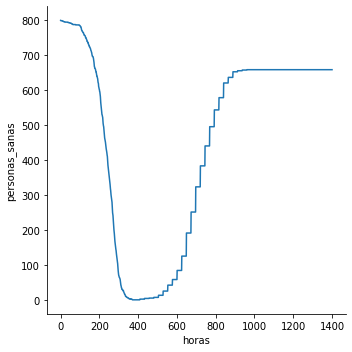

In [97]:
MiSimulador=Simulador(numpersonas,personasedificio,mediaincubacion,desvincubacion,mediaduracion ,desvduracion,posibilidadContagio ,cambioEstadoInicial ) #numPersonas, personasEdificio 
print(MiSimulador)
#se crea un paciente que resulta ser el 0, pasandole 15 dias como dia para el cambio de estadp 
MiSimulador.contagio_fijo(cambioEstadoInicial) 
for i in range(horassimulacion): #horas que pasa la simulacion 
    '''
    Datos inventados:
    MediaIncubación:7 dias
    DesvIncubación:3 dias
    MediaDuracion:14 dias
    DescDuracion:5 dias
    '''
    MiSimulador.pasar_tiempo()
    if MiSimulador.hora==0:
        print("--------")
        print(" ")
        print(" ")
        print(MiSimulador.dia)
        print(MiSimulador.capacidades)
        print(MiSimulador)
        printearciudad(MiSimulador.ciudad)
        print(MiSimulador.personas_sanas())
        print(" ")
        print(" ")
        print("--------")
        print(" ")
        print(" ")
        MiSimulador.mostrarcementerio()
        print(" ")
        print(" ")
        print("--------")
MiSimulador.graficoPersonasSanas()

In [47]:
printearEdificio(MiSimulador.ciudad,0)

481,inmune,0,66726772T,11
531,inmune,0,15380732B,105


In [26]:
printearciudad(MiSimulador.ciudad)

68,inmune,3,56711266M,22

22,inmune,1,44622371W,57
18,inmune,1,81356210N,8
76,inmune,4,88524085Y,59
23,inmune,1,86670864X,4
32,inmune,1,42454783A,11
20,inmune,1,53428358W,78
3,inmune,1,27102032M,34
83,inmune,4,77414261X,56
72,inmune,4,25210143G,20
30,inmune,1,58846701M,39
48,inmune,2,1162457Z,63
88,inmune,4,33846622Y,15
57,inmune,2,71436206T,22
11,inmune,1,48667561K,107
93,inmune,4,68352384H,80
4,inmune,1,11776370W,28
43,inmune,2,4277068B,35
98,inmune,5,46154545P,101
97,inmune,5,60588057P,32
19,inmune,1,15120414F,10
65,inmune,3,34372778Z,100

8,inmune,1,53054467E,46
36,inmune,2,26306750V,18
89,inmune,4,34758580Z,78
80,inmune,4,72888650V,86
67,inmune,3,86035467B,91
53,inmune,2,8833281Q,63
15,inmune,1,2846257F,85
50,inmune,2,13316802D,39
84,inmune,4,60008807J,36
2,inmune,1,43602763F,64
29,inmune,1,80645358K,47
55,inmune,2,41147331D,35
64,inmune,3,58076113D,101
44,inmune,2,3608884T,92
35,inmune,1,41825024F,92
59,inmune,2,30124532Y,9
78,inmune,4,18158546T,9
25,inmune,1,5302348C,34
79,inmun

In [22]:
MiSimulador.actualizar_catalogo()
for i in range(len(MiSimulador.CatalogoPersonas)):
                print(MiSimulador.CatalogoPersonas[i])
            

0,inmune,0,41346858B,39
1,inmune,0,61030308S,100
2,inmune,0,73157278M,105
3,inmune,0,3033250X,94
4,inmune,0,24748873E,36
5,inmune,0,5576471Y,92
7,inmune,0,2741510W,27
8,inmune,1,74735882G,15
9,inmune,1,30286524D,31
10,inmune,1,72102300Z,9
11,inmune,1,62056185T,54
12,inmune,1,43120135B,4
13,inmune,1,56541618M,91
14,inmune,1,52247400W,25
15,inmune,1,33820583A,109
16,inmune,1,87370240W,26
17,inmune,1,7174735T,83
18,inmune,1,71524072Y,5
19,inmune,1,22400335Z,57
20,inmune,1,66521463N,88
21,inmune,1,21234004J,17
23,inmune,1,31557041Y,38
24,inmune,1,5442744R,60
26,inmune,1,30844074Q,11
27,inmune,1,32222356T,48
29,inmune,1,16682350J,60
30,inmune,1,2233032P,94
31,inmune,1,47463222P,61
32,inmune,1,17562203R,39
33,inmune,1,88226076P,93
34,inmune,1,14014243K,97
35,inmune,1,85757332S,9
37,inmune,1,17018043K,12
38,inmune,1,65376104F,18
39,inmune,1,54851248C,48
40,inmune,2,25563008A,58
42,inmune,2,78055840G,13
43,inmune,2,60861216L,52
44,inmune,2,46265681P,88
45,inmune,2,38673830C,10
46,inmune,2,5465

In [28]:
personitaputa=MiSimulador.cogerpersona(0)
print(personitaputa.contadorInfecciones)

4


In [167]:
MiSimulador=Simulador(100,10) 
print(MiSimulador.capacidades)
print(len(MiSimulador.ciudad))

[23  1 29  7 22 16  2]
0,sano,0,87204200E,7
1,sano,0,81351675P,65
2,sano,0,7541462S,84
3,sano,0,2734837E,49
4,sano,0,67118311X,62
5,sano,0,63653820D,41
6,sano,0,56840305Z,104
7,sano,0,71438685H,88
8,sano,0,37235031D,2
9,sano,0,24211256F,28
10,sano,0,76816004Y,83
11,sano,0,25172814G,49
12,sano,0,75582883F,33
13,sano,0,65767330A,93
14,sano,0,22875655Q,88
15,sano,0,11256111A,85
16,sano,0,87500174D,37
17,sano,0,23444251Y,63
18,sano,0,50162442V,58
19,sano,0,52664477C,99
20,sano,0,10176827V,22
21,sano,0,57341107Z,72
22,sano,0,32625576F,67
23,sano,1,76036012J,70
24,sano,2,26170230W,84
25,sano,2,30847235A,11
26,sano,2,78242507A,47
27,sano,2,12318218Q,13
28,sano,2,3440412A,53
29,sano,2,32441324P,31
30,sano,2,26126301A,94
31,sano,2,28610526K,51
32,sano,2,27767452N,105
33,sano,2,50417272F,78
34,sano,2,2504088D,32
35,sano,2,57177760J,40
36,sano,2,31066118H,88
37,sano,2,76265586R,79
38,sano,2,68173116N,58
39,sano,2,35280872E,52
40,sano,2,34084064L,36
41,sano,2,6287818D,23
42,sano,2,11550463R,81
43,

In [48]:
print(MiSimulador.RegistroSanos)

[800, 799, 799, 799, 799, 799, 799, 799, 799, 799, 799, 799, 799, 799, 798, 798, 797, 796, 794, 793, 793, 793, 791, 790, 790, 790, 789, 789, 788, 787, 787, 787, 787, 787, 787, 787, 786, 785, 785, 785, 785, 783, 783, 783, 782, 781, 781, 781, 780, 778, 776, 773, 769, 768, 764, 761, 758, 757, 755, 750, 747, 744, 743, 741, 738, 736, 735, 732, 728, 727, 726, 723, 723, 721, 720, 717, 714, 713, 711, 711, 709, 707, 704, 703, 699, 695, 693, 689, 687, 686, 682, 681, 680, 677, 674, 674, 671, 668, 661, 657, 652, 649, 645, 640, 635, 628, 619, 614, 607, 605, 596, 590, 584, 579, 575, 571, 567, 560, 553, 548, 545, 539, 511, 492, 475, 456, 439, 422, 412, 402, 382, 372, 365, 351, 341, 329, 317, 310, 298, 291, 281, 268, 259, 249, 242, 239, 220, 199, 193, 175, 166, 157, 148, 137, 122, 116, 107, 101, 94, 90, 80, 75, 69, 67, 64, 60, 58, 54, 50, 46, 39, 30, 27, 23, 18, 15, 12, 10, 8, 7, 7, 7, 5, 5, 5, 4, 4, 4, 3, 3, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

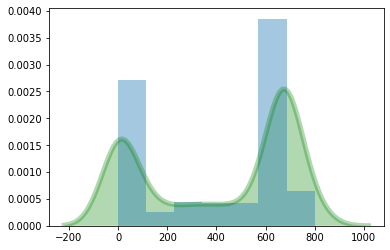

In [57]:
sns.distplot( a=MiSimulador.RegistroSanos, hist=True, kde=True,
             kde_kws={"color": "g", "alpha":0.3, "linewidth": 5, "shade":True }
, rug=False )


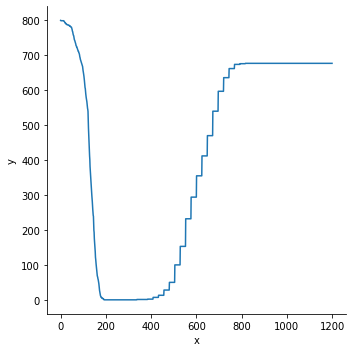

In [72]:
arr=np.reshape(MiSimulador.RegistroSanos, (1201, 1)).T[0]
sns.relplot(x="x",y="y", kind="line", data=data)

In [66]:
arr=np.reshape(MiSimulador.RegistroSanos, (1201, 1)).T[0]
arr

array([800, 799, 799, ..., 677, 677, 677])

In [71]:
data=pd.DataFrame({'x':range(0,len(MiSimulador.RegistroSanos)),'y':arr})
data

,x,y
0,0,800
1,1,799
2,2,799
3,3,799
4,4,799
...,...,...
1196,1196,677
1197,1197,677
1198,1198,677
1199,1199,677
